### **Phase 1: Player Detection and Initial Analysis** 🏃‍♂️⚽️

1. **YOLOv11 Fine-Tuning for Player Detection** 🎯
   - Adapt YOLOv11 for detecting football players on the field.
   - **Objective**: Ensure robust detection of players, even under challenging scenarios like crowded scenes or varying lighting conditions.

In [ ]:
import torch
print(torch.backends.mps.is_available())
print(torch.cuda.is_available())

False
True


In [10]:
!yolo task=detect mode=train model="/content/drive/MyDrive/FootCVision/utils/yolo11s.pt" data="/content/drive/MyDrive/dataset/data.yaml" epochs=10 imgsz=640 device=0

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/FootCVision/utils/yolo11s.pt, data=/content/drive/MyDrive/dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

**Fine-tuned YOLOv11s Model Summary**

Model Specifications:
- **Architecture:** YOLOv11s (fused)
- **Layers:** 238 layers
- **Parameters:** 9,414,348
- **Gradients:** 0 gradients
- **FLOPs (Floating Point Operations):** 21.3 GFLOPs

Inference Speed:
- **Preprocessing Time:** 0.3ms per image
- **Inference Time:** 4.7ms per image
- **Loss Calculation Time:** 0.0ms per image
- **Postprocessing Time:** 2.7ms per image

---

### Performance Metrics:

| **Class**       | **Images** | **Instances** | **Precision (P)** | **Recall (R)** | **mAP@50** | **mAP@50-95** |
|-----------------|------------|---------------|-------------------|----------------|------------|---------------|
| **All**         | 588        | 4137          | 0.923             | 0.897          | 0.928      | 0.633         |
| **Ball**        | 538        | 611           | 0.891             | 0.769          | 0.845      | 0.594         |
| **Goalkeeper**  | 115        | 116           | 0.973             | 0.924          | 0.974      | 0.623         |
| **Player**      | 181        | 3074          | 0.938             | 0.961          | 0.961      | 0.682         |
| **Referee**     | 171        | 336           | 0.890             | 0.935          | 0.932      | 0.634         |

Inference Speed:
- **Total Speed:** 1.68 iterations per second


![RESULTS](/Users/alyazouzou/Desktop/CV_Football/FootCVision/phase1/runs/detect/train/results.png)

1.3 **Inference on a Video** !

In [145]:
!yolo task=detect mode=predict model="/Users/alyazouzou/Desktop/CV_Football/FootCVision/phase1/runs/detect/train/weights/best.pt" source="/Users/alyazouzou/Desktop/CV_Football/vids/good.mov" device=mps project="/Users/alyazouzou/Desktop/CV_Football/vids" name="output2"

Ultralytics 8.3.57 🚀 Python-3.9.21 torch-2.5.1 MPS (Apple M3)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

video 1/1 (frame 1/4159) /Users/alyazouzou/Desktop/CV_Football/vids/good.mov: 384x640 1 ball, 10 players, 190.4ms
video 1/1 (frame 2/4159) /Users/alyazouzou/Desktop/CV_Football/vids/good.mov: 384x640 1 ball, 9 players, 12.0ms
video 1/1 (frame 3/4159) /Users/alyazouzou/Desktop/CV_Football/vids/good.mov: 384x640 1 ball, 9 players, 11.5ms
video 1/1 (frame 4/4159) /Users/alyazouzou/Desktop/CV_Football/vids/good.mov: 384x640 1 ball, 8 players, 12.2ms
video 1/1 (frame 5/4159) /Users/alyazouzou/Desktop/CV_Football/vids/good.mov: 384x640 1 ball, 8 players, 19.9ms
video 1/1 (frame 6/4159) /Users/alyazouzou/Desktop/CV_Football/vids/good.mov: 384x640 1 ball, 8 players, 14.7ms
video 1/1 (frame 7/4159) /Users/alyazouzou/Desktop/CV_Football/vids/good.mov: 384x640 1 ball, 9 players, 14.0ms
video 1/1 (frame 8/4159) /Users/alyazouzou/Desktop/CV_Football/vids

2. **Conformal Object Detection with puncc library** 📏

![Pipeline](/Users/alyazouzou/Desktop/CV_Football/rendu/re.png)

In [11]:
import os
import glob
import numpy as np
from PIL import Image
from inference import PlayerInference
from odwrapper import YOLOAPIWrapper

from deel.puncc.object_detection import SplitBoxWise
from deel.puncc.metrics import object_detection_mean_coverage, object_detection_mean_area, iou
from ultralytics import YOLO
from sklearn.model_selection import train_test_split

In [12]:
dataset_path = "/Users/alyazouzou/Desktop/CV_Football/calib"

def parse_yolo_dataset(images_paths, labels_paths, percentage=0.1, random_seed=42):
    """
    Parse a subset of the YOLO dataset (e.g., 1%) and extract image paths, ground truth boxes, and labels.
    
    Args:
        images_paths (List[str]): List of paths to image folders (train, test, val).
        labels_paths (List[str]): List of paths to label folders (train, test, val).
        percentage (float): Percentage of data to parse (e.g., 0.01 for 1%).
        random_seed (int): Random seed for reproducibility.
    
    Returns:
        Tuple[List[str], List[np.ndarray], List[List[int]]]: Subsampled image paths, ground truth boxes, and labels.
    """
    # Initialize lists to store data
    image_paths = []
    ground_truth_boxes = []
    all_labels = []

    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Iterate over the image and label directories
    for images_path, labels_path in zip(images_paths, labels_paths):
        # Get all label files in the current labels directory
        label_files = glob.glob(os.path.join(labels_path, "*.txt"))

        # Determine the number of files to sample
        total_files = len(label_files)
        sample_size = int(percentage * total_files)

        # Randomly select a subset of files
        sampled_files = np.random.choice(label_files, size=sample_size, replace=True)

        # Process each sampled label file
        for label_file in sampled_files:
            with open(label_file, "r") as f:
                labels = f.readlines()

            # Extract bounding boxes and associated class IDs
            boxes = []
            labels_per_image = []
            for label in labels:
                parts = list(map(float, label.strip().split()))
                class_id, x_center, y_center, width, height = parts
                # Normalizing the bounding box coordinates
                image_file = os.path.join(images_path, os.path.basename(label_file).replace(".txt", ".jpg"))
                image = Image.open(image_file)
                image_width, image_height = image.size
                x_center *= image_width
                y_center *= image_height
                width *= image_width
                height *= image_height
                # Converting YOLO format to bounding box (x1, y1, x2, y2)
                x1 = x_center - (width / 2)
                y1 = y_center - (height / 2) 
                x2 = x_center + (width / 2)
                y2 = y_center + (height / 2) 
                # Convert to numpy array and append to boxes
                boxes.append([x1, y1, x2, y2])
                labels_per_image.append(int(class_id))

            # Add the image path, boxes, and labels
            image_file = os.path.join(images_path, os.path.basename(label_file).replace(".txt", ".jpg"))
            image_paths.append(image_file)
            ground_truth_boxes.append(np.array(boxes))
            all_labels.append(labels_per_image)

    return image_paths, ground_truth_boxes, all_labels


# Example usage with train, test, and validation directories
train_images_path = os.path.join(dataset_path, "train/images")
train_labels_path = os.path.join(dataset_path, "train/labels")
val_images_path = os.path.join(dataset_path, "val/images")
val_labels_path = os.path.join(dataset_path, "val/labels")
test_images_path = os.path.join(dataset_path, "test/images")
test_labels_path = os.path.join(dataset_path, "test/labels")

# List of image and label paths for each folder
image_paths, ground_truth_boxes, all_labels = parse_yolo_dataset(
    images_paths=[train_images_path, val_images_path, test_images_path],
    labels_paths=[train_labels_path, val_labels_path, test_labels_path],
    percentage=0.99,  # You can change the percentage based on your needs
    random_seed=42
)

# Convert to numpy arrays for compatibility with puncc
X = np.array(image_paths)
y = np.array(ground_truth_boxes, dtype=object)  
labels = np.array(all_labels, dtype=object)  

# We use dtype=object for variable-length arrays - this is necessary for puncc - because the number of boxes per image can vary

# We split the data into training and validation sets
X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(
    X, y, labels, test_size=0.2, random_state=42
)

After getting our train set that is considered as our calibration set for conformal prediction, we have to create a wrapper of my YOLO fine-tuned model. This is necessary to ensure that we have stored **X_pred** (which is the prediction done by the fine tuned model for all images on the train set) & **X_ground_truth** (which is the ground truth).

In [14]:
yolo_api = YOLOAPIWrapper(model_path="/Users/alyazouzou/Desktop/CV_Football/FootCVision/phase1/runs/detect/train/weights/best.pt")

In [15]:
# example of prediction and matching
print(yolo_api.predict_and_match(X_train[0], y_train[0]))


image 1/1 /Users/alyazouzou/Desktop/CV_Football/calib/train/images/08fd33_3_10_png_jpg.rf.4029868cf77c533518095532c45d6f85.jpg: 640x640 1 goalkeeper, 19 players, 3 referees, 92.1ms
Speed: 0.8ms preprocess, 92.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
(array([[     216.16,      155.69,      223.24,      180.62],
       [     154.84,      245.19,      163.29,      274.23],
       [     625.08,      228.71,      632.63,      260.14],
       [     278.42,      194.78,      284.45,      225.92],
       [     201.03,      182.13,      208.12,      208.37],
       [     414.35,      200.74,      424.99,      230.05],
       [     176.12,      222.73,      185.05,       256.3],
       [     365.37,      168.22,      375.31,      192.45],
       [     183.11,      225.75,      191.81,      259.74],
       [     154.39,      264.64,      162.93,      298.98],
       [     340.07,      223.38,      349.64,      254.57],
       [     331.21,      222.73,      338.53,   

In [16]:
from deel.puncc.api.prediction import IdPredictor
from deel.puncc.object_detection import SplitBoxWise

# we create the proxy for the object detection model as suggested in the documentation
api_model = IdPredictor()

In [19]:
# we call the query method to get the predictions and the matched ground truth boxes which are our calibration data
y_preds, y_trues_matched, images, classes = yolo_api.query(X_train, y_train, labels_train)

print("Predictions:", y_preds)
print("Matched Ground Truths:", y_trues_matched)
print("Images:", images)
print("Classes:", classes)

Predictions: [[     216.16      155.69      223.24      180.62]
 [     433.33      144.56      440.34      171.56]
 [     154.84      245.19      163.29      274.23]
 ...
 [     217.27       430.1      233.53      498.77]
 [     576.74      202.27      584.69      241.93]
 [     552.23      326.46      568.68      387.59]]
Matched Ground Truths: [[     216.25      156.75      222.75      180.25]
 [     434.25      146.25      441.75      172.75]
 [        155         246         163         273]
 ...
 [     217.75         430      234.25         498]
 [     577.25      204.25      583.75      241.75]
 [        553      329.25         569      386.75]]
Images: ['/Users/alyazouzou/Desktop/CV_Football/calib/train/images/08fd33_3_10_png_jpg.rf.4029868cf77c533518095532c45d6f85.jpg', '/Users/alyazouzou/Desktop/CV_Football/calib/train/images/42ba34_3_4_png_jpg.rf.68c0f37b856b7d12f7e1709eedf2d7e7.jpg', '/Users/alyazouzou/Desktop/CV_Football/calib/train/images/49725_jpg.rf.1a2180c842e6d018b0b27

In [20]:
# we instantiate the conformal predictor
conformal_predictor = SplitBoxWise(api_model, method="multiplicative", train=False)

# fitting the conformal predictor on the calibration data
conformal_predictor.fit(X_calib=y_preds, y_calib=y_trues_matched)

**Inference on one Test Image**

In [44]:
# Select an image from the test dataset
image_path, bboxes, classes = X_val[189], y_val[189], labels_val[189]
#print(bboxes.shape)

# Predict on the image
y_new_api = yolo_api.predict_from_image(image_path)
#print(y_new_api.shape)
#print(y_new_api)

# the coverage target 1-alpha
alpha = 0.3

# Inference + UQ
y_pred_new, box_inner, box_outer = conformal_predictor.predict(y_new_api, alpha=alpha)
#print(box_outer.shape)
#print(box_outer)

# Convert the predictions for comparison necessary for the plotting
classes = [str(class_) for class_ in classes]
y_pred_new_t = tuple(map(tuple, y_pred_new))
bboxes_t = tuple(map(tuple, bboxes))
box_inner_t = tuple(map(tuple, box_inner))
box_outer_t= tuple(map(tuple, box_outer))
image = Image.open(image_path)


image 1/1 /Users/alyazouzou/Desktop/CV_Football/calib/train/images/4b770a_7_4_png_jpg.rf.a22c428598a3876f7883e14e7af121a2.jpg: 640x640 20 players, 2 referees, 98.3ms
Speed: 2.1ms preprocess, 98.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


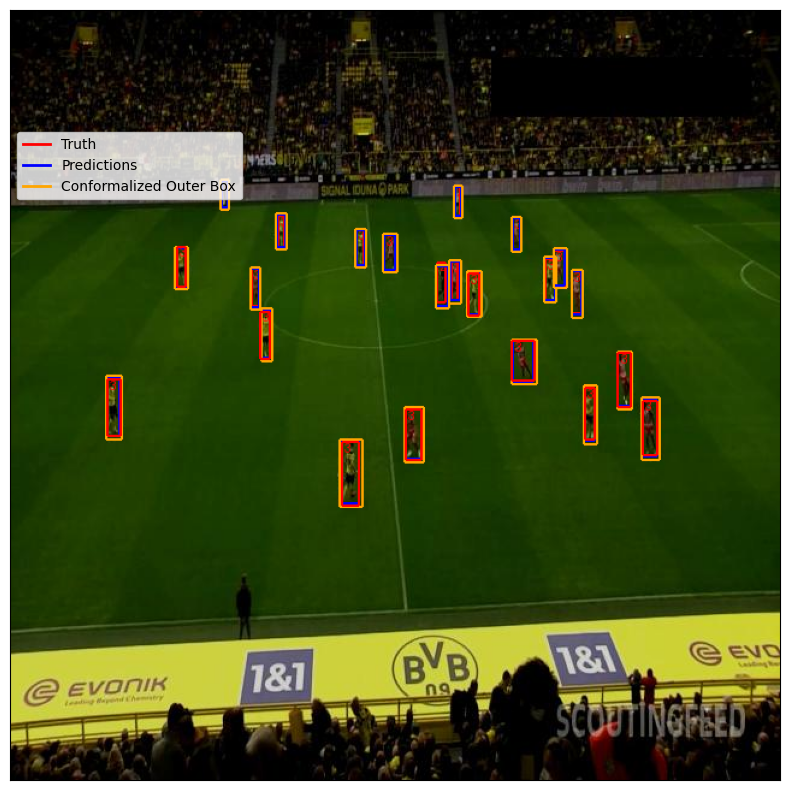

In [45]:
from deel.puncc.plotting import draw_bounding_box

for i in range(len(y_pred_new)):
    image_with_bbox = draw_bounding_box(
        image=image,
        box=bboxes_t[i],
        label=classes[i],
        legend="Truth",
        color="red",
    )
    image_with_bbox = draw_bounding_box(
        image=image,
        box=y_pred_new_t[i],
        legend="Predictions",
        color="blue",
    )
    image_with_bbox = draw_bounding_box(
        image=image,
        box=box_outer_t[i],
        legend="Conformalized Outer Box",
        color="orange",
    )
    
    # image_with_bbox = draw_bounding_box(
    #     image=image_with_bbox,
    #     box=box_inner[i],
    #     legend="Conformalized Inner Box",
    #     color="brown",
    # )

_ = draw_bounding_box(image=image, show=True)

In [47]:
# Compute marginal coverage and average width of the prediction intervals
coverage = object_detection_mean_coverage(box_outer, y_new_api)
average_area = object_detection_mean_area(box_outer)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average area: {np.round(average_area, 2)}")

Marginal coverage: 1.0
Average area: 508.8399963378906


**Inference on All Test Image**

In [48]:
def infer_cp_on_test_set(X_val, y_val, labels_val, conformal_predictor, yolo_api):
    """
    Infer the conformal predictor on the test set.
    Args:
        X_val (np.ndarray): Test set image paths.
        y_val (np.ndarray): Test set ground truth boxes.
        labels_val (np.ndarray): Test set labels.
        conformal_predictor (deel.puncc.api.conformal_predictor.ConformalPredictor): Conformal predictor.
        yolo_api (odwrapper.YOLOAPIWrapper): YOLO API wrapper.
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Predictions, ground truth boxes, images, classes, inner boxes, outer boxes.
    """
    y_pred_val = []
    y_true_val = []
    images_val = []
    classes_val = []
    box_inner_val = []
    box_outer_val = []

    for i in range(len(X_val)):
        image_path, y_true, classes = X_val[i], y_val[i], labels_val[i]
        # Predict on the image
        y_new_api = yolo_api.predict_from_image(image_path)

        image = Image.open(image_path)

        # Choose the coverage target 1-alpha
        alpha = 0.3

        # Inference + UQ
        y_pred_new, box_inner, box_outer = conformal_predictor.predict(y_new_api, alpha=alpha)
        # ADD SORTING
        # Get sorting indices based on all columns (sort from last column to first)
        sort_indices_outer = np.lexsort(box_outer.T[::-1])
        box_outer = box_outer[sort_indices_outer]
        sort_indices_true = np.lexsort(y_true.T[::-1])
        y_true = y_true[sort_indices_true]
        sort_indices_pred = np.lexsort(y_pred_new.T[::-1])
        y_pred_new = y_pred_new[sort_indices_pred]

        # Append the results
        #y_pred_new = tuple(map(tuple, y_pred_new))
        #y_true = tuple(map(tuple, y_true))
        #box_inner = tuple(map(tuple, box_inner))
        #box_outer= tuple(map(tuple, box_outer))

        y_pred_val.append(y_pred_new)
        y_true_val.append(y_true)
        images_val.append(image)
        classes_val.append(classes)
        box_inner_val.append(box_inner)
        box_outer_val.append(box_outer)

    return y_pred_val, y_true_val, images_val, classes_val, box_inner_val, box_outer_val

# we call the function to get the predictions and the UQ bounds
y_pred_val, y_true_val, images_val, classes_val, box_inner_val, box_outer_val = infer_cp_on_test_set(X_val, y_val, labels_val, conformal_predictor, yolo_api)


image 1/1 /Users/alyazouzou/Desktop/CV_Football/calib/train/images/08fd33_0_6_png_jpg.rf.b01edbc4781b9714754d52beede6626d.jpg: 640x640 20 players, 2 referees, 94.0ms
Speed: 1.1ms preprocess, 94.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/alyazouzou/Desktop/CV_Football/calib/train/images/54745b_9_7_png_jpg.rf.7d62c0a0001c525811141a4ddf0c0995.jpg: 640x640 1 ball, 18 players, 3 referees, 88.2ms
Speed: 0.7ms preprocess, 88.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/alyazouzou/Desktop/CV_Football/calib/train/images/51395_jpg.rf.fec2c01468ec7403982a8a73aad4272c.jpg: 640x640 9 players, 94.5ms
Speed: 1.1ms preprocess, 94.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/alyazouzou/Desktop/CV_Football/calib/train/images/798b45_1_7_png_jpg.rf.f8154592cd1e820e29cb0cb97b8d0754.jpg: 640x640 1 goalkeeper, 20 players, 3 referees, 84.2ms
Speed: 0.7ms preprocess, 84.2ms inference

**Evaluation of our Conformal Predictor**

In [49]:
average_glo_area = []
for i in range(len(box_outer_val)):
    if(len(box_outer_val[i]) == 0):
       continue
    average_area = object_detection_mean_area(box_outer_val[i])
    average_glo_area.append(average_area)

print(f"Average area of prediction intervals: {np.mean(average_glo_area)}")
print(f"Average length of prediction intervals: {np.sqrt(np.mean(average_glo_area))}")

Average area of prediction intervals: 745.5555419921875
Average length of prediction intervals: 27.30486297607422


In [67]:
cover = []
for i in range(len(y_pred_val)):
    if(box_outer_val[i].shape == y_pred_val[i].shape):
        coverage = object_detection_mean_coverage(box_outer_val[i], y_pred_val[i])
        coverage = np.round(coverage, 2)
        cover.append(coverage)
print(f"Marginal coverage between CP and Prediction: {np.mean(cover)}")

Marginal coverage between CP and Prediction: 0.9920392156862745


In [68]:
print(cover[1:255])

[1.0, 1.0, 0.92, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.88, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91, 1.0, 0.85, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.82, 1.0, 1.0, 1.0, 1.0, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.85, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91, 1.0, 0.92, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92, 0.91, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92, 1.0,

In [58]:
cover = []
for i in range(len(y_pred_val)):
    if(box_outer_val[i].shape == y_true_val[i].shape):
        coverage = object_detection_mean_coverage(box_outer_val[i], y_true_val[i])
        coverage = np.round(coverage, 2)
        cover.append(coverage)
print(f"Marginal coverage between CP and GT if shape correspond: {np.mean(cover)}")

Marginal coverage between CP and GT if shape correspond: 0.4707407407407407


In [59]:
print(cover[1:10])

[0.76, 0.08, 0.45, 0.87, 0.7, 0.22, 0.62, 0.0, 0.75]


In [65]:
import numpy as np

def compute_iou_for_all(y_pred_val, box_outer_val):
    """
    Calcule l'IoU pour chaque boîte dans chaque image.

    :param y_pred_val: Liste de tableaux numpy contenant des boîtes pour chaque image.
    :param box_outer_val: Liste de tableaux numpy contenant des boîtes pour chaque image.

    :return: Liste de matrices IoU pour chaque image.
    """
    all_ious = []  # Stocke les matrices IoU de chaque image

    # Vérifier que les listes ont la même longueur
    num_images = min(len(y_pred_val), len(box_outer_val))

    for i in range(num_images):
        # Récupérer les boîtes de la ième image
        pred_boxes = y_pred_val[i]  # (N, 4)
        outer_boxes = box_outer_val[i]  # (M, 4)

        if pred_boxes.shape[0] == 0 or outer_boxes.shape[0] == 0:
            # S'il n'y a pas de boîtes dans l'une des listes, l'IoU est vide
            #all_ious.append(np.array([]))
            continue

        # Calcul de l'IoU entre toutes les boîtes de `pred_boxes` et `outer_boxes`
        iou_matrix = iou(pred_boxes, outer_boxes)  # Résultat (N, M)

        all_ious.append(iou_matrix)  # Ajouter la matrice IoU pour cette image

    return all_ious

# Exécution de la fonction
ious_per_image = compute_iou_for_all(y_pred_val, box_outer_val)

In [66]:
import numpy as np

def mean_diagonal_iou(ious_per_image):
    """
    Calcule l'IoU moyen en utilisant uniquement les valeurs diagonales des matrices IoU.

    :param ious_per_image: Liste de matrices numpy contenant les IoU pour chaque image.
    :return: IoU moyen sur toutes les images.
    """
    diagonal_ious = []

    for i, iou_matrix in enumerate(ious_per_image):
        if isinstance(iou_matrix, np.ndarray) and iou_matrix.size > 0:
            if iou_matrix.ndim == 2 and iou_matrix.shape[0] == iou_matrix.shape[1]:  # Vérifie si c'est une matrice carrée
                diagonal_ious.extend(np.diag(iou_matrix))  # Récupère la diagonale
            else:
                print(f"[⚠️] Image {i}: Ignoré (matrice non carrée ou vide, shape {iou_matrix.shape})")
        else:
            print(f"[⚠️] Image {i}: Ignoré (pas de matrice ou vide)")

    if len(diagonal_ious) == 0:
        return 0  # Évite une erreur si aucune diagonale n'est trouvée

    return np.mean(diagonal_ious)  # Calcul de la moyenne

# Calcul de l'IoU moyen
iou_mean = mean_diagonal_iou(ious_per_image)

# Affichage du résultat
print(f"IoU moyen sur les diagonales: {iou_mean:.5f}")

IoU moyen sur les diagonales: 0.76630
